In [1]:
import h5py
import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns
from tqdm import tqdm


/home/ahojel/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
device = torch.device("cuda:4" if torch.cuda.is_available() else "cpu")

def compute_metric(data_list, labels_list, dim=148):
    data = torch.tensor(np.array(data_list)).to(device) 
    overall_data_mean = torch.mean(data, dim=0)
    bcss = torch.zeros(dim, device=device)
    wcss = torch.zeros(dim, device=device)

    unique_labels = list(set(labels_list))
    
    #unique_labels = [label for label in unique_labels if not label in ['label_inpaint black square']]
    
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_list_number = torch.tensor([label_dict[label] for label in labels_list]).to(device)

    for group_label in set(labels_list_number):
        
        group_indices = torch.nonzero(labels_list_number == group_label, as_tuple=False).squeeze()
        group_data = data[group_indices]
        
        group_mean = torch.mean(group_data, dim=0)

        current_bcss = len(group_indices) * torch.sum((group_mean - overall_data_mean) ** 2, dim=1)
        current_wcss = torch.sum((group_data - group_mean) ** 2, dim=(0,2))

        bcss += current_bcss
        wcss += current_wcss

    ratios = bcss / wcss
    assert ratios.shape[0] == dim
    return ratios.cpu()

In [7]:
def compute_layerwise_dunn_index(data_list, labels_list):
    data = torch.tensor(np.array(data_list)).to(device)  # Shape [# of examples, # of layers, dimension]
    unique_labels = list(set(labels_list))
    
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_list_number = torch.tensor([label_dict[label] for label in labels_list]).to(device)
    
    layerwise_dunn_indices = []
    
    for layer in range(data.shape[1]):  # Iterate through each layer
        layer_data = data[:, layer, :]  # Select all examples for the current layer
        
        min_intercluster_distance = float('inf')
        max_intracluster_distance = float('-inf')
        
        for i, label_i in enumerate(unique_labels):
            data_i = layer_data[labels_list_number == label_dict[label_i]]
            
            for j, label_j in enumerate(unique_labels):
                if i == j:
                    continue
                data_j = layer_data[labels_list_number == label_dict[label_j]]
                
                # Calculate the minimum distance between clusters i and j
                if data_i.size(0) > 0 and data_j.size(0) > 0:  # Ensure both clusters have data
                    dists = torch.cdist(data_i, data_j)
                    min_dist_ij = torch.min(dists)
                    min_intercluster_distance = min(min_intercluster_distance, min_dist_ij)
                
            # Calculate the maximum distance within cluster i
            if data_i.size(0) > 1:  # Ensure cluster has more than one data point
                intra_dists = torch.cdist(data_i, data_i)
                max_dist_i = torch.max(intra_dists)
                max_intracluster_distance = max(max_intracluster_distance, max_dist_i)
        
        dunn_index = min_intercluster_distance / max_intracluster_distance
        layerwise_dunn_indices.append(dunn_index.cpu())
    
    return layerwise_dunn_indices


In [6]:
def compute_layerwise_davies_bouldin_index(data_list, labels_list):
    data = torch.tensor(np.array(data_list)).to(device)  # Shape [# of examples, # of layers, dimension]
    unique_labels = list(set(labels_list))
    
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_list_number = torch.tensor([label_dict[label] for label in labels_list]).to(device)
    
    layerwise_db_indices = []
    
    for layer in range(data.shape[1]):  # Iterate through each layer
        layer_data = data[:, layer, :]  # Select all examples for the current layer
        db_indices = []
        
        for i, label_i in enumerate(unique_labels):
            data_i = layer_data[labels_list_number == label_dict[label_i]]
            centroid_i = torch.mean(data_i, dim=0)
            sigma_i = torch.mean(torch.norm(data_i - centroid_i, dim=1))
            
            max_ratio = float('-inf')
            for j, label_j in enumerate(unique_labels):
                if i == j:
                    continue
                data_j = layer_data[labels_list_number == label_dict[label_j]]
                centroid_j = torch.mean(data_j, dim=0)
                sigma_j = torch.mean(torch.norm(data_j - centroid_j, dim=1))
                
                d_centroids = torch.norm(centroid_i - centroid_j)
                ratio = (sigma_i + sigma_j) / d_centroids if d_centroids != 0 else float('inf')
                max_ratio = max(max_ratio, ratio)
            
            db_indices.append(max_ratio)
        
        db_index = sum(db_indices) / len(db_indices) if db_indices else float('inf')
        layerwise_db_indices.append(db_index.cpu())
    
    return layerwise_db_indices


In [7]:
def compute_fluffy_layerwise_dunn_index(data_list, labels_list):
    data = torch.tensor(np.array(data_list)).to(device)  # Shape [# of examples, # of layers, dimension]
    unique_labels = list(set(labels_list))
    
    label_dict = {label: index for index, label in enumerate(unique_labels)}
    labels_list_number = torch.tensor([label_dict[label] for label in labels_list]).to(device)
    
    layerwise_dunn_indices = []
    
    for layer in range(data.shape[1]):  # Iterate through each layer
        layer_data = data[:, layer, :]  # Select all examples for the current layer
        
        intercluster_distances = []
        intracluster_distances = []
        
        for i, label_i in enumerate(unique_labels):
            data_i = layer_data[labels_list_number == label_dict[label_i]]
            
            for j, label_j in enumerate(unique_labels):
                if i == j:
                    continue
                data_j = layer_data[labels_list_number == label_dict[label_j]]
                
                # Calculate distances between clusters i and j
                if data_i.size(0) > 0 and data_j.size(0) > 0:  # Ensure both clusters have data
                    dists = torch.cdist(data_i, data_j)
                    intercluster_distances.extend(dists.view(-1).sort()[0][:5].tolist())  # Get the 5 smallest distances
                
            # Calculate distances within cluster i
            if data_i.size(0) > 1:  # Ensure cluster has more than one data point
                intra_dists = torch.cdist(data_i, data_i)
                intracluster_distances.extend(intra_dists.view(-1).sort(descending=True)[0][:5].tolist())  # Get the 5 largest distances
        
        avg_min_intercluster_distance = sum(intercluster_distances) / len(intercluster_distances) if intercluster_distances else float('inf')
        avg_max_intracluster_distance = sum(intracluster_distances) / len(intracluster_distances) if intracluster_distances else float('-inf')
        
        dunn_index = avg_min_intercluster_distance / avg_max_intracluster_distance if avg_max_intracluster_distance != 0 else 0
        layerwise_dunn_indices.append(dunn_index)
    
    return layerwise_dunn_indices


In [3]:
alpha_labels = ['segmentation', "colorization", "inpaint single random", "lowlight enhance"]

In [4]:
import h5py
import torch
import numpy as np
from tqdm import tqdm

def load_data(h5file_path):
    data_store = {}
    with h5py.File(h5file_path, 'r') as h5file:
        for pass_name, pass_group in tqdm(h5file.items()):
            if pass_name.startswith('pass_'):
                data_store[pass_name] = {}
                for label_name, label_group in pass_group.items():
                    if label_name in alpha_labels:
                        # Read the entire dataset for this label in this pass

                        try:
                            item = label_group['encoder_latent'][:, 0, :, :] #- pass_group[label_name+"_neutral"]['decoder_latent'][:, 0, :, :]
                        except:
                            print(pass_name, label_name)
                            continue
                        data_store[pass_name][label_name] = item
    return data_store

def compute_metric_for_layer_and_head(data, labels, layer, head, dim=148):
    # Slice the data for the specific layer and head
    data_list = [d[layer, :, head] for d in data]
    return compute_metric(data_list, labels, dim)

# Load data once
data_store = load_data("/home/ahojel/visual_prompting_vid/output_dir/residual_attention1/dataset.hdf5")


  0%|          | 0/170 [00:00<?, ?it/s]

 37%|███▋      | 63/170 [07:56<13:34,  7.61s/it]

pass_2009_000440___2010_000238 segmentation


 78%|███████▊  | 133/170 [17:04<04:39,  7.56s/it]

In [1]:
stacked_matrix

NameError: name 'stacked_matrix' is not defined

In [10]:
len(data_store)

170

In [ ]:
encoder_metric_holder = []
for layer in tqdm(range(24)):
    for head in range(16):
        data = []
        labels = []
        for pass_name, pass_data in data_store.items():
            for label_name, item in pass_data.items():
                data.append(item[layer,:,head])
                labels.append(label_name)

        regular = compute_metric(data, labels)
        encoder_metric_holder.append(regular)


100%|██████████| 8/8 [00:56<00:00,  7.03s/it]


In [24]:
len(encoder_metric_holder[0])

197

In [ ]:
decoder_metric_holder = []
for layer in tqdm(range(8)):
    data = []
    labels = []
    for pass_name, pass_data in data_store.items():
        for label_name, item in pass_data.items():
            data.append(item[layer,:].sum(1))
            labels.append(label_name)

    regular = compute_metric(data, labels, dim=197)
    decoder_metric_holder.append(regular)


In [ ]:
labels

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Calculate cosine similarity between consecutive data points and flatten the result to a 1D array for histogram plotting
similarity_scores = [cosine_similarity(data[a].reshape(1, -1), data[a+1].reshape(1, -1)).flatten() for a in range(len(data)-1)]
plt.hist(similarity_scores, bins=50)
plt.show()


In [ ]:
len(data)

In [ ]:
len(decoder_metric_holder)

In [ ]:
encoder_matrix = torch.vstack(encoder_metric_holder)
decoder_matrix = torch.vstack(decoder_metric_holder)
padding_width = decoder_matrix.shape[1] - encoder_matrix.shape[1]
padded_encoder_matrix = torch.nn.functional.pad(encoder_matrix, (0, padding_width))
stacked_matrix = torch.vstack([padded_encoder_matrix, decoder_matrix])

In [ ]:
decoder_matrix = torch.vstack(encoder_metric_holder)# torch.tensor(encoder_metric_holder)
stacked_matrix = decoder_matrix

In [20]:
decoder_matrix.shape

torch.Size([384, 148])

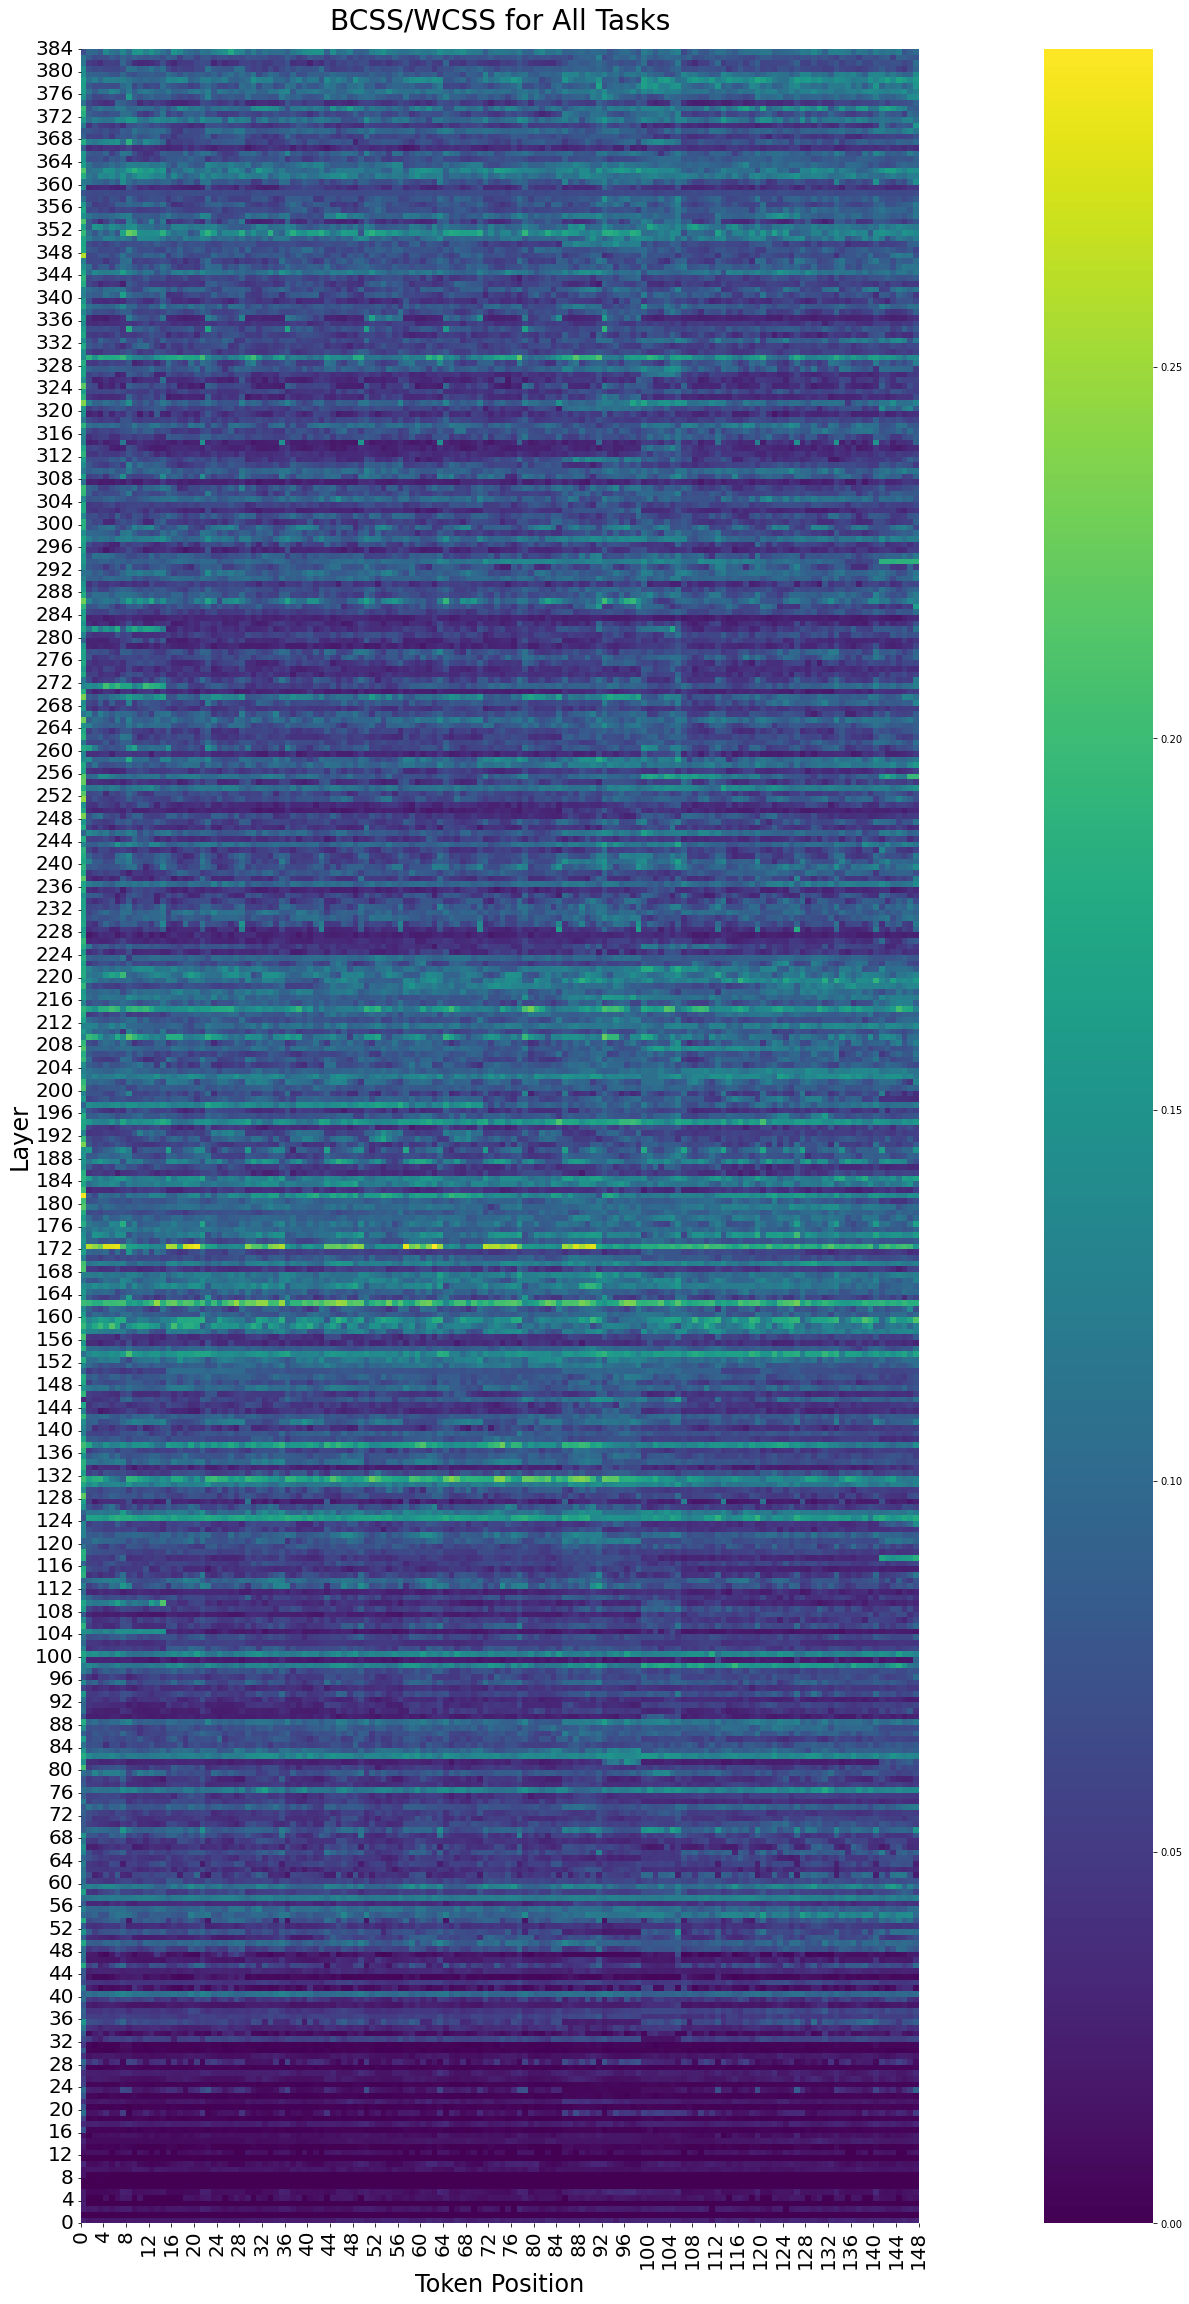

In [21]:
def plot_widemap(matrix_data, title):

    # Creating the heatmap
    plt.figure(figsize=(45, 40))  # Adjust the figure size as needed
    sns.heatmap(matrix_data, cmap='viridis', square=True)

    # Setting the labels for axes
    plt.xlabel('Token Position', fontsize=24)
    plt.ylabel('Layer', fontsize=24)

    # Inverting the y-axis to have the first layer at the bottom
    plt.gca().invert_yaxis()

    # Adding title
    plt.title(title, fontsize=28, pad=20)
    plt.yticks(np.arange(0, matrix_data.shape[0]+1, 4), np.arange(0, matrix_data.shape[0]+1, 4), fontsize=20)
    plt.xticks(np.arange(0, matrix_data.shape[1]+1, 4), np.arange(0, matrix_data.shape[1]+1, 4), fontsize=20)

    plt.show()

plot_widemap(stacked_matrix, 'BCSS/WCSS for All Tasks')

In [15]:
import torch

def unpatchify_adapted(x):
    """
    x: (N, 196)
    imgs: (N, 14, 14)
    """
    h = w = 14  # Image dimensions
    imgs = x.reshape(x.shape[0], h, w)
    return imgs

def create_special_image(pixels):
    # Initialize an empty 14x14 array
    image = torch.zeros(14, 14)

    # Fill the top half (7 rows) with the first 98 pixels
    top_half = torch.tensor(pixels[:98]).reshape(7, 14)
    image[:7, :] = top_half

    # Fill the bottom-left quadrant with the next 49 pixels
    bottom_left_quadrant = torch.tensor(pixels[98:]).reshape(7, 7)
    image[7:, :7] = bottom_left_quadrant

    return image

def batch_process(stacked_matrix, decoder_only=False, encoder_only=False):
    # Split the matrix into two parts
    if decoder_only:
        full_images = stacked_matrix
        combined = unpatchify_adapted(full_images)
    elif encoder_only:
        special_images = stacked_matrix
        combined = torch.stack([create_special_image(img) for img in special_images])
    else:
        special_images = stacked_matrix[:24, :147]  # First 24 images, first 147 pixels
        full_images = stacked_matrix[24:,]       # Last 8 images, excluding the first pixel


    # Process the special images
        special_processed = torch.stack([create_special_image(img) for img in special_images])

    # Process the full images
        full_processed = unpatchify_adapted(full_images)

    # Combine the results
        combined = torch.cat((special_processed, full_processed), dim=0)
    return combined


In [31]:
stacked_matrix.shape

torch.Size([128, 197])

In [16]:
batched_images = batch_process(stacked_matrix[:, 1:], encoder_only=True)

/tmp/ipykernel_4065868/876215758.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  top_half = torch.tensor(pixels[:98]).reshape(7, 14)
/tmp/ipykernel_4065868/876215758.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  bottom_left_quadrant = torch.tensor(pixels[98:]).reshape(7, 7)


In [ ]:
batched_images.shape

In [ ]:
h = batched_images
batched_images = batched_images[:4*16]

In [ ]:
stacked_matrix

In [ ]:
filtered_values = stacked_matrix.reshape(-1).numpy()
filtered_values = filtered_values[filtered_values < 100]
plt.hist(filtered_values, bins=50, log=True)


In [45]:
stacked_matrix.shape

torch.Size([384, 148])

In [ ]:
batched_images = h

/tmp/ipykernel_4065868/274395692.py:42: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the rect to account for the added colorbar axis


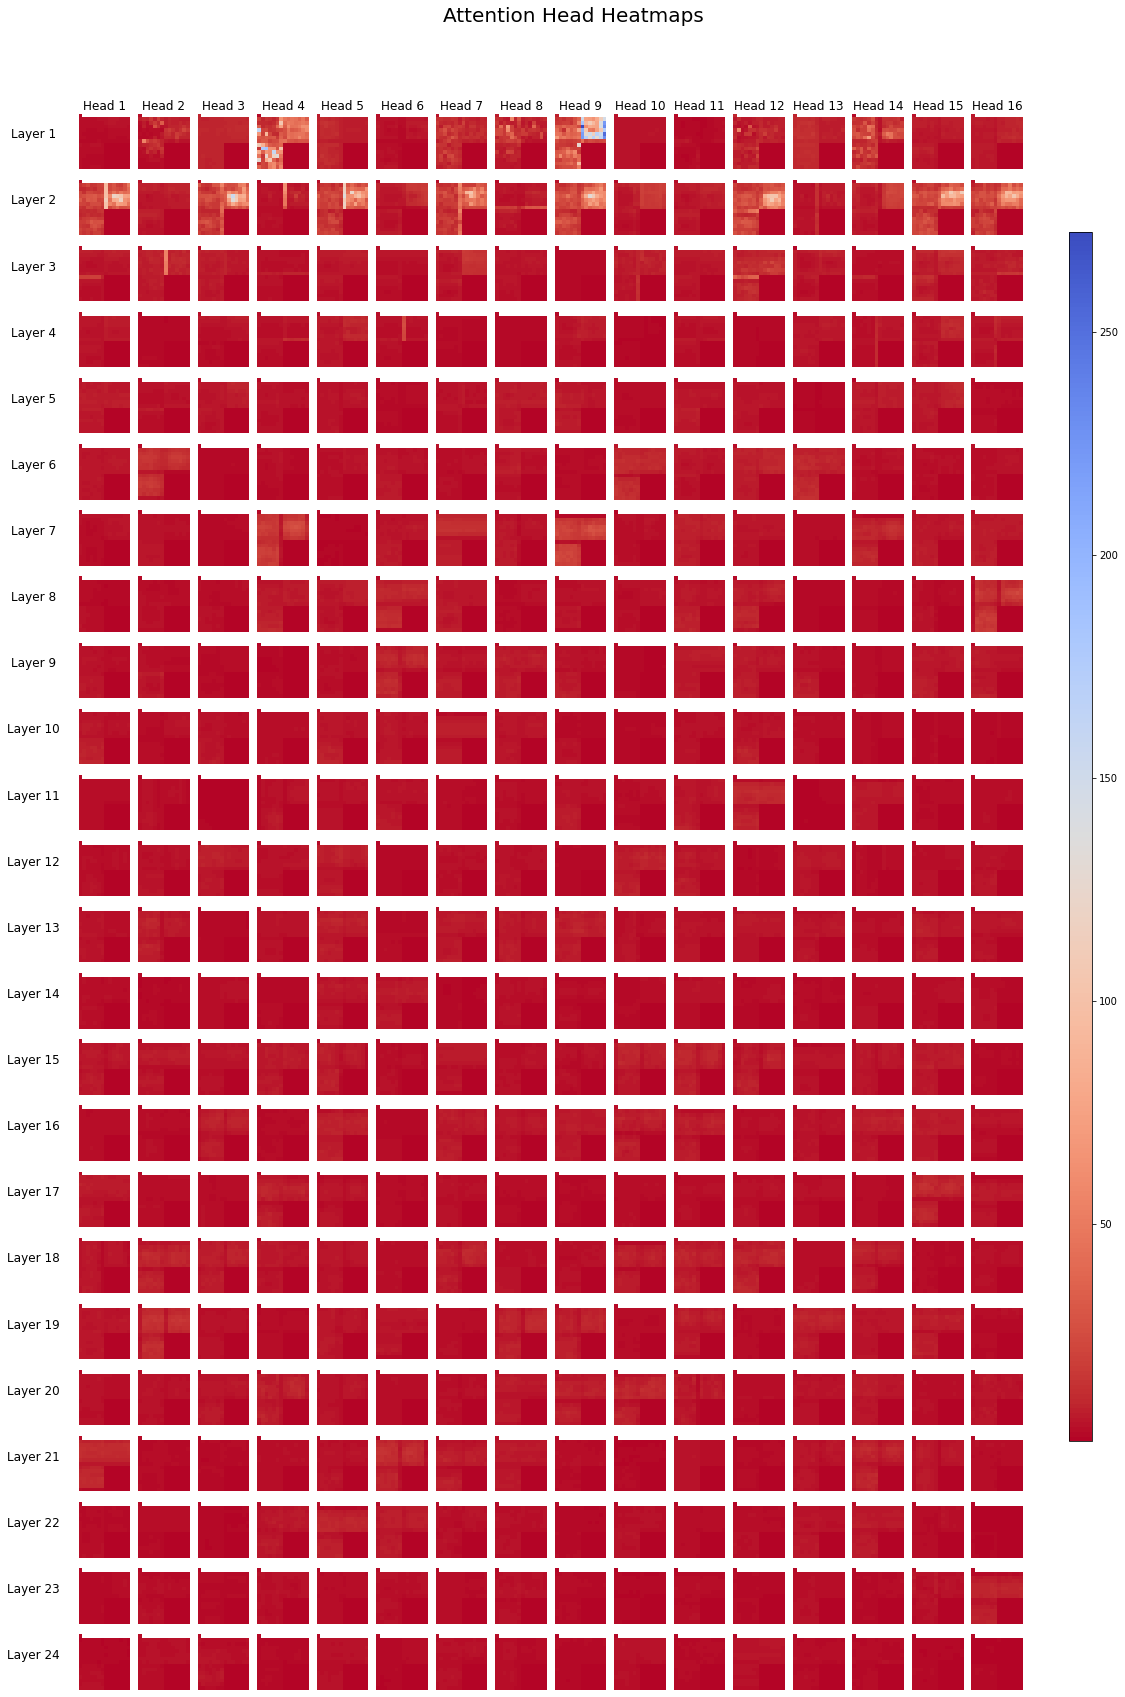

In [17]:
# Find global min and max for consistent color range across all heatmaps
global_min = stacked_matrix.min()
global_max = stacked_matrix.max()

batched_alpha_pixel = stacked_matrix[:, :1].squeeze()

# Set up the matplotlib figure with 24 rows and 16 columns for images and alpha_pixel indicators
fig, axes = plt.subplots(24, 16, figsize=(16, 24))  # Adjust the figure size as needed
fig.patch.set_facecolor('white')  # Set the background to white

# Generate heatmaps for each image with an additional alpha pixel
for i, ax in enumerate(axes.flatten()):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i]  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i]      # Place the original image below

    # Plot the extended heatmap
    sns.heatmap(extended_matrix, cmap='coolwarm_r', ax=ax, cbar=False, square=True,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_xticks([])
    ax.set_yticks([])

# Create an axis for the color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="coolwarm_r", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Add the main title
plt.suptitle('Attention Head Heatmaps', fontsize=20)

# Set the labels for layers and heads
axes[0, 0].set_ylabel('Layer 1', rotation=0, size='large', labelpad=45)
for i in range(1, 24):
    axes[i, 0].set_ylabel(f'Layer {i+1}', rotation=0, size='large', labelpad=45)
for j in range(16):
    axes[0, j].set_xlabel(f'Head {j+1}', size='large')
    axes[0, j].xaxis.set_label_position('top') 

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the rect to account for the added colorbar axis
plt.show() 

In [ ]:
# Find global min and max for consistent color range across all heatmaps
global_min = 1/stacked_matrix.max()
global_max = 1/stacked_matrix.min()

batched_alpha_pixel = stacked_matrix[:, :1].squeeze()

# Set up the matplotlib figure with 24 rows and 16 columns for images and alpha_pixel indicators
fig, axes = plt.subplots(8, 16, figsize=(16, 8))  # Adjust the figure size as needed
fig.patch.set_facecolor('white')  # Set the background to white

# Generate heatmaps for each image with an additional alpha pixel
for i, ax in enumerate(axes.flatten()):
    # Create a 15x14 matrix with NaNs and place the alpha_pixel at the top left
    extended_matrix = np.full((15, 14), np.nan)
    extended_matrix[0, 0] = batched_alpha_pixel[i]  # Set the top left to the alpha_pixel value
    extended_matrix[1:, :] = batched_images[i]      # Place the original image below

    # Plot the extended heatmap
    sns.heatmap(1/extended_matrix, cmap='coolwarm', ax=ax, cbar=False, square=True,
                vmin=global_min, vmax=global_max, mask=np.isnan(extended_matrix))
    ax.set_xticks([])
    ax.set_yticks([])

# Create an axis for the color bar on the right side
cbar_ax = fig.add_axes([0.93, 0.15, 0.02, 0.7])  # x, y, width, height
norm = plt.Normalize(global_min, global_max)
sm = plt.cm.ScalarMappable(cmap="coolwarm", norm=norm)
sm.set_array([])
fig.colorbar(sm, cax=cbar_ax)

# Add the main title
plt.suptitle('Attention Head Heatmaps', fontsize=20)

# Set the labels for layers and heads
axes[0, 0].set_ylabel('Layer 1', rotation=0, size='large', labelpad=45)
for i in range(1, 8):
    axes[i, 0].set_ylabel(f'Layer {i+1}', rotation=0, size='large', labelpad=45)
for j in range(16):
    axes[0, j].set_xlabel(f'Head {j+1}', size='large')
    axes[0, j].xaxis.set_label_position('top') 

plt.tight_layout(rect=[0, 0, 0.9, 0.95])  # Adjust the rect to account for the added colorbar axis
plt.show()

In [8]:
normed = stacked_matrix.norm(dim=-1)


In [43]:
stacked_matrix.shape

torch.Size([128, 197])

In [11]:
stacked_matrix.shape

torch.Size([384, 148])

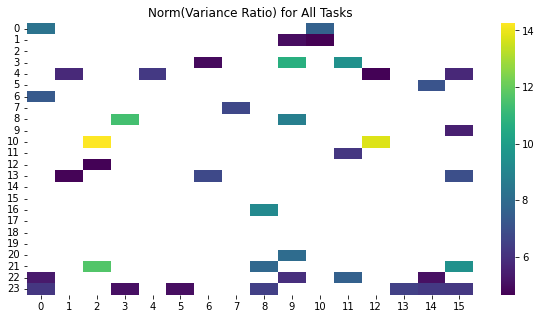

In [9]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Example 1D tensor of shape [128]
# stacked_matrix = torch.rand(128)  # Assuming this is your tensor

# Reshape the tensor to 8 rows and 16 columns
reshaped_matrix = normed.reshape(24, 16)

# Convert to NumPy array for plotting
matrix_np = reshaped_matrix.numpy()  # If requires_grad=True for the tensor, use reshaped_matrix.detach().numpy()

# Set all the ones less than the top 10 as None and masked out
flat = matrix_np.flatten()
threshold = np.sort(flat)[-40]  # Find the 10th largest value
mask = matrix_np < threshold  # Create a mask for values below the threshold
matrix_np_masked = np.where(mask, np.nan, matrix_np)  # Apply mask and replace with np.nan instead of None
matrix_np_masked = matrix_np_masked.reshape(24, 16)
mask = mask.reshape(24, 16)

# Plotting the heatmap
plt.figure(figsize=(10, 5))  # Adjust the figure size as necessary
sns.heatmap(matrix_np_masked, annot=False, cmap='viridis', cbar=True, mask=np.isnan(matrix_np_masked))
plt.title('Norm(Variance Ratio) for All Tasks')
plt.show()


In [8]:
# Print the (layer, head, position) indices of all values in order of greatest to least
sorted_indices = np.argsort(-stacked_matrix.numpy().flatten())  # Sort indices by value in descending order
sorted_positions = [[index // (16*148), (index % (16*148)) // 148, index % 148] for index in sorted_indices]
print(sorted_positions)


[[23, 13, 0], [4, 4, 22], [10, 2, 97], [4, 4, 8], [8, 3, 79], [10, 2, 96], [4, 4, 92], [10, 2, 98], [10, 12, 42], [8, 3, 65], [8, 3, 80], [10, 12, 84], [10, 12, 56], [10, 12, 70], [10, 12, 28], [10, 2, 41], [10, 2, 40], [10, 12, 27], [10, 12, 26], [10, 12, 97], [4, 4, 98], [8, 3, 92], [10, 12, 23], [10, 12, 94], [10, 12, 13], [10, 12, 98], [8, 3, 66], [10, 12, 55], [10, 12, 12], [8, 3, 81], [10, 12, 11], [10, 12, 69], [10, 12, 66], [4, 1, 22], [10, 2, 28], [10, 12, 96], [10, 12, 65], [10, 2, 27], [10, 2, 26], [10, 12, 95], [10, 12, 14], [8, 3, 93], [10, 12, 79], [10, 12, 83], [10, 2, 54], [10, 2, 42], [10, 12, 25], [10, 12, 80], [10, 12, 37], [8, 3, 94], [10, 12, 93], [4, 4, 97], [10, 12, 68], [10, 2, 14], [10, 12, 40], [4, 4, 93], [10, 12, 41], [10, 2, 95], [10, 12, 82], [10, 2, 13], [10, 12, 54], [10, 12, 53], [10, 2, 39], [10, 12, 51], [8, 3, 95], [10, 2, 55], [10, 12, 38], [8, 3, 82], [10, 12, 81], [10, 12, 10], [10, 2, 56], [10, 12, 52], [10, 12, 9], [10, 2, 69], [8, 3, 51], [10, 

In [44]:
import torch

# Assuming q1, q2, q3 are defined elsewhere in the code
q1, q2, q3, q4 = set(q1), set(q2), set(q3), set(q4)

# Function to assign group based on the rule
def assign_group(i):
    if i == 0:
        return "cls"
    elif i - 1 in q1:
        return "1"
    elif i - 1 in q2:
        return "2"
    elif i - 1 in q3:
        return "3"
    else:
        return "4"

# Apply grouping rule and compute average for each group
group_labels = [assign_group(i) for i in range(stacked_matrix.shape[1])]
grouped_averages = []

for layer in stacked_matrix:
    layer_groups = {}
    for i, val in enumerate(layer):
        group = group_labels[i]
        if group not in layer_groups:
            layer_groups[group] = []
        layer_groups[group].append(val.item())
    layer_averages = {group: torch.mean(torch.tensor(values)) for group, values in layer_groups.items()}
    grouped_averages.append(layer_averages)

# Assuming the desire is to convert the dictionary to a tensor with shape [layer, group_count]
group_counts = max(len(layer_avg) for layer_avg in grouped_averages)
averages_tensor = torch.zeros((stacked_matrix.shape[0], group_counts))

for i, layer_avg in enumerate(grouped_averages):
    for j, (group, avg) in enumerate(layer_avg.items()):
        averages_tensor[i, j] = avg

averages_tensor.shape


torch.Size([128, 5])

In [45]:
sorted_indices = np.argsort(-averages_tensor.numpy().flatten())  # Sort indices by value in descending order
sorted_positions = [[index // (16*5), (index % (16*5)) // 5, index % 5] for index in sorted_indices]
print(sorted_positions)

[[1, 2, 4], [1, 2, 2], [4, 15, 0], [6, 11, 0], [2, 7, 2], [3, 9, 0], [6, 7, 4], [3, 8, 4], [1, 2, 0], [1, 2, 1], [7, 1, 0], [0, 15, 0], [0, 15, 4], [1, 7, 0], [3, 8, 2], [1, 2, 3], [5, 0, 0], [4, 9, 4], [0, 7, 2], [6, 3, 4], [6, 2, 0], [6, 0, 4], [4, 7, 0], [4, 3, 4], [5, 4, 4], [1, 7, 4], [4, 3, 2], [2, 0, 4], [4, 3, 3], [4, 3, 1], [5, 7, 4], [2, 14, 0], [5, 15, 4], [0, 3, 4], [0, 3, 2], [0, 15, 2], [2, 10, 1], [3, 15, 0], [2, 10, 3], [2, 10, 2], [3, 3, 0], [2, 10, 4], [3, 3, 4], [5, 15, 2], [3, 0, 4], [4, 13, 2], [7, 1, 4], [2, 10, 0], [2, 7, 4], [4, 13, 0], [0, 3, 3], [0, 7, 0], [4, 9, 2], [2, 0, 2], [1, 8, 0], [1, 15, 2], [0, 3, 1], [6, 0, 0], [1, 10, 4], [6, 12, 4], [6, 11, 4], [4, 13, 4], [2, 14, 4], [4, 10, 0], [0, 3, 0], [2, 2, 0], [3, 9, 4], [5, 15, 0], [6, 5, 4], [0, 7, 4], [1, 10, 0], [7, 10, 0], [5, 2, 2], [5, 12, 4], [6, 14, 0], [1, 8, 2], [5, 2, 3], [5, 6, 0], [6, 2, 4], [7, 15, 0], [3, 4, 4], [7, 13, 3], [5, 2, 1], [3, 1, 0], [7, 13, 4], [6, 7, 2], [7, 13, 1], [4, 6, 4],

In [46]:
for i in range(len(sorted_positions)):
    curr = sorted_positions[i] 
    if curr[2]==0:
        sorted_positions[i] = [[sorted_positions[i][0]+24,sorted_positions[i][1],sorted_positions[i][2]]]
    elif curr[2]==1:
        sorted_positions[i] = [[sorted_positions[i][0]+24,sorted_positions[i][1],a] for a in q1]
    elif curr[2]==2:
        sorted_positions[i] = [[sorted_positions[i][0]+24,sorted_positions[i][1],a] for a in q2]
    elif curr[2]==3:
        sorted_positions[i] = [[sorted_positions[i][0]+24,sorted_positions[i][1],a] for a in q3]
    elif curr[2]==4:
        sorted_positions[i] = [[sorted_positions[i][0]+24,sorted_positions[i][1],a] for a in q4]



In [25]:
import pickle

# Pickle dump the 'holder' dictionary
with open('ranked_tokens.pkl', 'wb') as file:
    pickle.dump(holder, file)

In [2]:
import pickle
# Read the 'holder' dictionary from a pickle file
with open('ranked_tokens.pkl', 'rb') as file:
    holder = pickle.load(file)


In [52]:
len(holder["metric"]['decoder'])

25216

In [23]:
temp

[[[23, 13, 0]],
 [[10, 12, 8],
  [10, 12, 9],
  [10, 12, 10],
  [10, 12, 11],
  [10, 12, 12],
  [10, 12, 13],
  [10, 12, 14],
  [10, 12, 22],
  [10, 12, 23],
  [10, 12, 24],
  [10, 12, 25],
  [10, 12, 26],
  [10, 12, 27],
  [10, 12, 28],
  [10, 12, 36],
  [10, 12, 37],
  [10, 12, 38],
  [10, 12, 39],
  [10, 12, 40],
  [10, 12, 41],
  [10, 12, 42],
  [10, 12, 50],
  [10, 12, 51],
  [10, 12, 52],
  [10, 12, 53],
  [10, 12, 54],
  [10, 12, 55],
  [10, 12, 56],
  [10, 12, 64],
  [10, 12, 65],
  [10, 12, 66],
  [10, 12, 67],
  [10, 12, 68],
  [10, 12, 69],
  [10, 12, 70],
  [10, 12, 78],
  [10, 12, 79],
  [10, 12, 80],
  [10, 12, 81],
  [10, 12, 82],
  [10, 12, 83],
  [10, 12, 84],
  [10, 12, 92],
  [10, 12, 93],
  [10, 12, 94],
  [10, 12, 95],
  [10, 12, 96],
  [10, 12, 97],
  [10, 12, 98]],
 [[5, 4, 0]],
 [[10, 2, 8],
  [10, 2, 9],
  [10, 2, 10],
  [10, 2, 11],
  [10, 2, 12],
  [10, 2, 13],
  [10, 2, 14],
  [10, 2, 22],
  [10, 2, 23],
  [10, 2, 24],
  [10, 2, 25],
  [10, 2, 26],
  [10, 2,

In [21]:
a = [item for row in temp for item in row]

In [24]:
holder["grouped_metric"]['encoder'] = temp

In [20]:
for index in range(len(temp)):
    temp[index] = [[x[0], x[1], x[2]] for x in temp[index] if x[2] < 148]


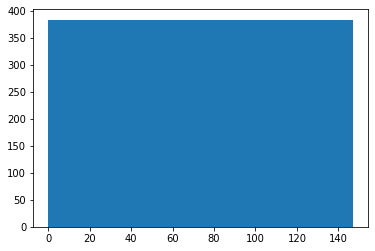

In [22]:
plt.hist([e[2] for e in a], bins=148)
plt.show()


In [3]:
holder["grouped_metric"]['encoder']

[[[23, 13, 0]],
 [[10, 12, 8],
  [10, 12, 9],
  [10, 12, 10],
  [10, 12, 11],
  [10, 12, 12],
  [10, 12, 13],
  [10, 12, 14],
  [10, 12, 22],
  [10, 12, 23],
  [10, 12, 24],
  [10, 12, 25],
  [10, 12, 26],
  [10, 12, 27],
  [10, 12, 28],
  [10, 12, 36],
  [10, 12, 37],
  [10, 12, 38],
  [10, 12, 39],
  [10, 12, 40],
  [10, 12, 41],
  [10, 12, 42],
  [10, 12, 50],
  [10, 12, 51],
  [10, 12, 52],
  [10, 12, 53],
  [10, 12, 54],
  [10, 12, 55],
  [10, 12, 56],
  [10, 12, 64],
  [10, 12, 65],
  [10, 12, 66],
  [10, 12, 67],
  [10, 12, 68],
  [10, 12, 69],
  [10, 12, 70],
  [10, 12, 78],
  [10, 12, 79],
  [10, 12, 80],
  [10, 12, 81],
  [10, 12, 82],
  [10, 12, 83],
  [10, 12, 84],
  [10, 12, 92],
  [10, 12, 93],
  [10, 12, 94],
  [10, 12, 95],
  [10, 12, 96],
  [10, 12, 97],
  [10, 12, 98]],
 [[5, 4, 0]],
 [[10, 2, 8],
  [10, 2, 9],
  [10, 2, 10],
  [10, 2, 11],
  [10, 2, 12],
  [10, 2, 13],
  [10, 2, 14],
  [10, 2, 22],
  [10, 2, 23],
  [10, 2, 24],
  [10, 2, 25],
  [10, 2, 26],
  [10, 2,

In [63]:
for z in range(len(holder["grouped_metric"]['encoder'])):
    if len(holder["grouped_metric"]['encoder'][z]) != 1:
        for inner in range(len(holder["grouped_metric"]['encoder'][z])):
            holder["grouped_metric"]['encoder'][z][inner][2] = holder["grouped_metric"]['encoder'][z][inner][2] + 1

In [67]:
a = holder["grouped_metric"]['encoder']

In [86]:
holder["grouped_metric"]['decoder']

[[26, 4, 129],
 [26, 4, 130],
 [26, 4, 131],
 [26, 4, 132],
 [26, 4, 133],
 [26, 4, 141],
 [26, 4, 142],
 [26, 4, 143],
 [26, 4, 144],
 [26, 4, 145],
 [26, 4, 146],
 [26, 4, 147],
 [26, 4, 155],
 [26, 4, 156],
 [26, 4, 157],
 [26, 4, 158],
 [26, 4, 159],
 [26, 4, 160],
 [26, 4, 161],
 [26, 4, 169],
 [26, 4, 170],
 [26, 4, 171],
 [26, 4, 172],
 [26, 4, 173],
 [26, 4, 174],
 [26, 4, 175],
 [26, 4, 183],
 [26, 4, 184],
 [26, 4, 185],
 [26, 4, 186],
 [26, 4, 187],
 [26, 4, 188],
 [26, 4, 189],
 [26, 4, 99],
 [26, 4, 100],
 [26, 4, 101],
 [26, 4, 102],
 [26, 4, 103],
 [26, 4, 104],
 [26, 4, 105],
 [26, 4, 113],
 [26, 4, 114],
 [26, 4, 115],
 [26, 4, 116],
 [26, 4, 117],
 [26, 4, 118],
 [26, 4, 119],
 [26, 4, 127],
 [26, 4, 128]]

In [65]:
with open('ranked_tokens.pkl', 'wb') as file:
    pickle.dump(holder, file)

In [66]:
holder["metric"]['encoder']

[[23, 13, 0],
 [4, 4, 22],
 [10, 2, 97],
 [4, 4, 8],
 [8, 3, 79],
 [10, 2, 96],
 [4, 4, 92],
 [10, 2, 98],
 [10, 12, 42],
 [8, 3, 65],
 [8, 3, 80],
 [10, 12, 84],
 [10, 12, 56],
 [10, 12, 70],
 [10, 12, 28],
 [10, 2, 41],
 [10, 2, 40],
 [10, 12, 27],
 [10, 12, 26],
 [10, 12, 97],
 [4, 4, 98],
 [8, 3, 92],
 [10, 12, 23],
 [10, 12, 94],
 [10, 12, 13],
 [10, 12, 98],
 [8, 3, 66],
 [10, 12, 55],
 [10, 12, 12],
 [8, 3, 81],
 [10, 12, 11],
 [10, 12, 69],
 [10, 12, 66],
 [4, 1, 22],
 [10, 2, 28],
 [10, 12, 96],
 [10, 12, 65],
 [10, 2, 27],
 [10, 2, 26],
 [10, 12, 95],
 [10, 12, 14],
 [8, 3, 93],
 [10, 12, 79],
 [10, 12, 83],
 [10, 2, 54],
 [10, 2, 42],
 [10, 12, 25],
 [10, 12, 80],
 [10, 12, 37],
 [8, 3, 94],
 [10, 12, 93],
 [4, 4, 97],
 [10, 12, 68],
 [10, 2, 14],
 [10, 12, 40],
 [4, 4, 93],
 [10, 12, 41],
 [10, 2, 95],
 [10, 12, 82],
 [10, 2, 13],
 [10, 12, 54],
 [10, 12, 53],
 [10, 2, 39],
 [10, 12, 51],
 [8, 3, 95],
 [10, 2, 55],
 [10, 12, 38],
 [8, 3, 82],
 [10, 12, 81],
 [10, 12, 10],
 

In [ ]:
alpha_labels = ['colorization', 'inpaint single random', 'lowlight enhance','segmentation']

In [ ]:
alpha_labels=["segmentation", "segmentation_neutral"]

In [ ]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/residual_attention1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape
    decoder_layers = first_element['segmentation']['decoder_latent'].shape
    print(encoder_layers, decoder_layers)
    data_list = []
    labels_list = []
    for pass_name, pass_group in tqdm(h5file.items()):
        for label_name, label_group in pass_group.items():
            if label_name in alpha_labels:
                item = label_group['encoder_latent'][:, 0, :, :]
                data_list.append(item)
                labels_list.append(label_name)


In [ ]:
tensors.shape

In [ ]:
holder = {}

for category in list(set(labels_list)):
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    subset = tensors[indices]

    print(subset.shape)
    holder[category] = subset.mean(0)

holder[category].shape

In [ ]:
import pickle

# Read the 'holder' dictionary from a pickle file
with open('holder_dict.pkl', 'rb') as file:
    tholder = pickle.load(file)

dict = {}
dict["encoder"]=holder
dict["decoder"]=tholder
dict

In [ ]:
import pickle

# Pickle dump the 'holder' dictionary
with open('holder_dict.pkl', 'wb') as file:
    pickle.dump(dict, file)

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch  # Ensure torch is importeda

In [ ]:
head = 3 - 1
layer = 22 - 1

In [ ]:
tensors[:,layer,:,head,:].shape

In [94]:
encoder_metric_holder = []
head = 11
layer = 21
data = []
labels = []
for pass_name, pass_data in data_store.items():
    for label_name, item in pass_data.items():
        data.append(item[layer,:,head])
        labels.append(label_name)

In [95]:
tensors = torch.tensor(np.array(data))

In [96]:
labels_list = labels

In [97]:
tensors.shape

torch.Size([680, 148, 1024])

In [89]:
all_latents.shape

(680, 49, 1024)

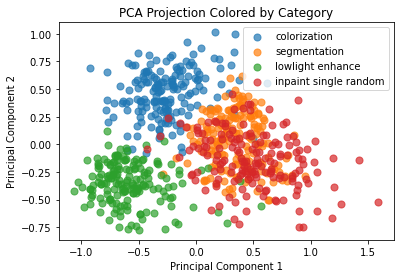

In [99]:
all_latents = tensors[:,0].numpy()#.reshape(680,49*1024).numpy()
#all_latents = np.array(tensors[:,q1])

pca = PCA(n_components=2)
pca_focus_result = pca.fit_transform(np.array(all_latents))

for category in list(set(labels_list)):
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    plt.scatter(pca_focus_result[indices, 0], pca_focus_result[indices, 1], s=50, alpha=0.7, label=category)  # Adjusted marker size

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()

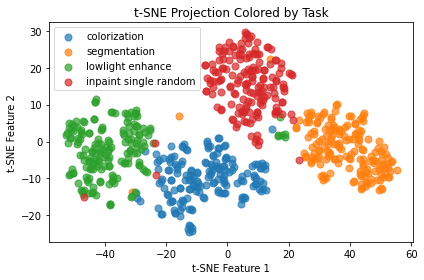

In [100]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(np.array(all_latents))

# Create a scatter plot with larger fonts and legend
for category in list(set(labels_list)):
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 50, alpha=0.7, label=category)

# Add plot title, labels, and legend with larger fonts
plt.title('t-SNE Projection Colored by Task')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()
 # Increase the legend marker size

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
all_latents = tensors[:,layer,:,head,:].reshape(680*148,1024).numpy()
#all_latents = tensors[:,layer,:,head,:].numpy()

In [ ]:
all_latents.shape

In [ ]:
subset = ['colorization', 'inpaint single random', 'lowlight enhance','segmentation']

In [ ]:
filtered_latents = [all_latents[i] for i, label in enumerate(labels_list) if label in ['segmentation']]
filtered_labels = [label for label in labels_list if label in ['segmentation']]


In [13]:
def calculate_quadrant_indices(rows, cols, quadrant):
    """
    Calculate the start and end indices for each quadrant in the flattened tensor.
    """
    row_start, row_end = 0, 7
    col_start, col_end = 0, 7
    
    if quadrant == 2:  # Top Right
        col_start, col_end = 7, 14
    elif quadrant == 3:  # Bottom Left
        row_start, row_end = 7, 14
    elif quadrant == 4:  # Bottom Right
        row_start, row_end = 7, 14
        col_start, col_end = 7, 14

    indices = []
    for row in range(row_start, row_end):
        for col in range(col_start, col_end):
            index = row * rows + col
            indices.append(index)
    
    return indices

In [14]:
q1 = calculate_quadrant_indices(14, 14, 1)
q2 = calculate_quadrant_indices(14, 14, 2)
q3 = calculate_quadrant_indices(14, 14, 3)
q4 = calculate_quadrant_indices(14, 14, 4)

In [ ]:
expanded_labels_list = np.repeat(labels_list, 148)
expanded_labels_list = np.array(["cls" if i % 197 == 0 else "1" if i % 197 - 1 in q1 else "2" if i % 197 - 1 in q2 else "3" if i % 197 - 1 in q3 else "4" for i, label in enumerate(expanded_labels_list)])

In [ ]:
pca = PCA(n_components=2)
pca_focus_result = pca.fit_transform(np.array(all_latents))

In [ ]:
# Adjusting the indices creation to account for the reshaped tensor

for category in list(set(expanded_labels_list)):
    # Select rows that belong to the current category
    indices = expanded_labels_list == category
    
    plt.scatter(pca_focus_result[indices, 0], pca_focus_result[indices, 1], s=10, alpha=0.1, label=category)

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
# Show the plot
plt.show()

In [ ]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(np.array(all_latents))

In [ ]:
len(labels_list)

In [ ]:
expanded_labels_list = np.repeat(labels_list, 148)

In [ ]:
# Create a scatter plot with larger fonts and legend
plt.figure(figsize=(20, 16))
for category in list(set(expanded_labels_list)):
    # Select rows that belong to the current category
    indices = expanded_labels_list == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 85, alpha=0.2, label=category)

# Add plot title, labels, and legend with larger fonts
plt.title('t-SNE Projection Colored by Task', fontsize=30)
plt.xlabel('t-SNE Feature 1', fontsize=16)
plt.ylabel('t-SNE Feature 2', fontsize=16)
leg = plt.legend(fontsize=24)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [350]  # Increase the legend marker size

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
len(expanded_labels_list)

In [ ]:
expanded_labels_list = np.array(["cls" if i % 148 == 0 else "1" if i % 148 - 1 in q1 else "2" if i % 148 - 1 in q2 else "3" for i, label in enumerate(expanded_labels_list)])

In [ ]:
# Create a scatter plot with larger fonts and legend
plt.figure(figsize=(20, 16))
for category in list(set(expanded_labels_list)):
    # Select rows that belong to the current category
    indices = expanded_labels_list == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 85, alpha=0.2, label=category)

# Add plot title, labels, and legend with larger fonts
plt.title('t-SNE Projection Colored by Task', fontsize=30)
plt.xlabel('t-SNE Feature 1', fontsize=16)
plt.ylabel('t-SNE Feature 2', fontsize=16)
leg = plt.legend(fontsize=24)
for lh in leg.legendHandles: 
    lh.set_alpha(1)
    lh._sizes = [350]  # Increase the legend marker size

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()

In [ ]:
# Open the file in read mode
with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/attention_1/dataset.hdf5", 'r') as h5file: 
    encoder_metric_holder = []
    first_element = next(iter(h5file.values()))
    
    encoder_layers = first_element['segmentation']['encoder_latent'].shape[0]
    decoder_layers = first_element['segmentation']['decoder_latent'].shape[0]
    print(encoder_layers, decoder_layers)
    data_list = []
    data_list_2 = []
    labels_list = []
    for pass_name, pass_group in tqdm(h5file.items()):
        if pass_name.startswith('pass_'):
            for label_name, label_group in pass_group.items():
                if label_name in alpha_labels:
                    item = label_group['decoder_latent'][:, 0, :, :] - pass_group[label_name+"_neutral"]['decoder_latent'][:, 0, :, :]
                    data_list.append(item)
                    labels_list.append(label_name)
                
tensors = torch.tensor(np.array(data_list))

for category in ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]:
    # Select rows that belong to the current category
    indices = np.array(labels_list) == category  # Ensure labels_list is in a compatible format
    
    curr = tensors[indices]
    avg = curr.mean(dim=0)

    new["decoder"][category]["avg_delta"] = avg

import pickle

with open('new.pkl', 'wb') as f:
    pickle.dump(new, f)

In [ ]:
new["decoder"]["colorization"]["avg_delta"].shape

In [ ]:
import pickle

with open('new.pkl', 'wb') as f:
    pickle.dump(new, f)

In [ ]:
new.keys()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import torch  # Ensure torch is importeda



focus_labels = ["colorization", "inpaint single random", "lowlight enhance", "segmentation"]

focus_indices = [i for i, label in enumerate(labels_list) if label in focus_labels]
focus_latents = [data_list[i] for i in focus_indices]
focus_labels = [labels_list[i] for i in focus_indices]

tensor_list = torch.tensor(focus_latents)

#focus_labels = label_list
#focus_latents = all_latents


In [ ]:


all_latents = torch.stack([latent.reshape(-1) for latent in tensor_list]).numpy()

pca = PCA(n_components=2)
pca_focus_result = pca.fit_transform(np.array(all_latents))

categories = list(set(focus_labels))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(focus_labels) == category  # Ensure labels_list is in a compatible format
    plt.scatter(pca_focus_result[indices, 0], pca_focus_result[indices, 1], s=50, alpha=0.7, label=category)  # Adjusted marker size

# Add plot title, labels, and legend
plt.title('PCA Projection Colored by Category')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()

# Show the plot
plt.show()


In [ ]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state=42)
features_2d = tsne.fit_transform(np.array(all_latents))

# Create a scatter plot
plt.figure(figsize=(10, 8))
categories = list(set(focus_labels))
for category in categories:
    # Select rows that belong to the current category
    indices = np.array(focus_labels) == category
    plt.scatter(features_2d[indices, 0], features_2d[indices, 1], 200, alpha=0.7, label=category)

# Add plot title, labels, and legend
plt.title('t-SNE Projection Colored by Category')
plt.xlabel('t-SNE Feature 1')
plt.ylabel('t-SNE Feature 2')
plt.legend()  # Places the legend to the right of the plot

# Adjust layout to make room for the legend
plt.tight_layout()
# Show the plot
plt.show()


In [ ]:

with h5py.File("/home/ahojel/visual_prompting_vid/output_dir/improv_collec_notext_t1/dataset.hdf5", 'r') as h5file: 
    avg_tensors = {}
    for i in tqdm(range(len(labels))):
        tensor_holder = []
        for pass_name, pass_group in h5file.items():
            tensor_holder.append(pass_group[labels[i]]['decoder_latent'][:,0])        
        print(len(tensor_holder))
        current_average = np.array(tensor_holder).mean(0)
        avg_tensors[labels[i]] = current_average

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Get the shape of the encoder
encoder_shape = avg_tensors["label_colorization"][0].shape
print(f'Encoder shape: {encoder_shape}')

# Reshape the encoder data and create a dataset
dataset = np.array([avg_tensors[k].reshape(-1) for k in avg_tensors.keys()])

# Perform PCA on the dataset
pca = PCA(n_components=6)
pca_result = pca.fit_transform(dataset)

# Plot the PCA result
for i, label in enumerate(avg_tensors.keys()):
    plt.scatter(pca_result[i, 0], pca_result[i, 1], label=label)

plt.legend()
plt.show()

# Plot the variance that each PC captures
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(6, 4))
plt.bar(range(6), explained_variance, alpha=0.5, align='center', label='individual explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [ ]:
stacked_decoder_data = [ele.reshape(4096) for ele in decoder_data_list]
stacked_encoder_data = [ele.reshape(24576) for ele in encoder_data_list]